# 

## Step 0: Library import and data preprocessing

In [132]:
from nrclex import NRCLex
import pandas as pd
from sklearn.cluster import k_means
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

Firstly, we import the data and examine its general information.

In [2]:
df = pd.read_csv("philosophy_data.csv")
df['n_tokens'] = list(map(len,map(eval,df.tokenized_txt)))
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


We could find that the dataset is quite clean (with no missing values), and contains information of 59 work titles, 36 different authors and 13 schools.

In [4]:
df.isna().sum().sum()

0

In [5]:
# total number of works, total number of authors, and total number of schools
df.title.value_counts().shape[0], df.author.value_counts().shape[0], df.school.value_counts().shape[0]

(59, 36, 13)

Next, we group the dataset by the schools and examine the total length distribution. From the barplot, we could see a relatively smooth distribution in the total sentence length, 11 out of 13 schools have more than 2e6 total words, and only stoicism has less than 1e6 total words, so by normalizing we are supposed to have a balanced dataset and feature distributions in most schools.

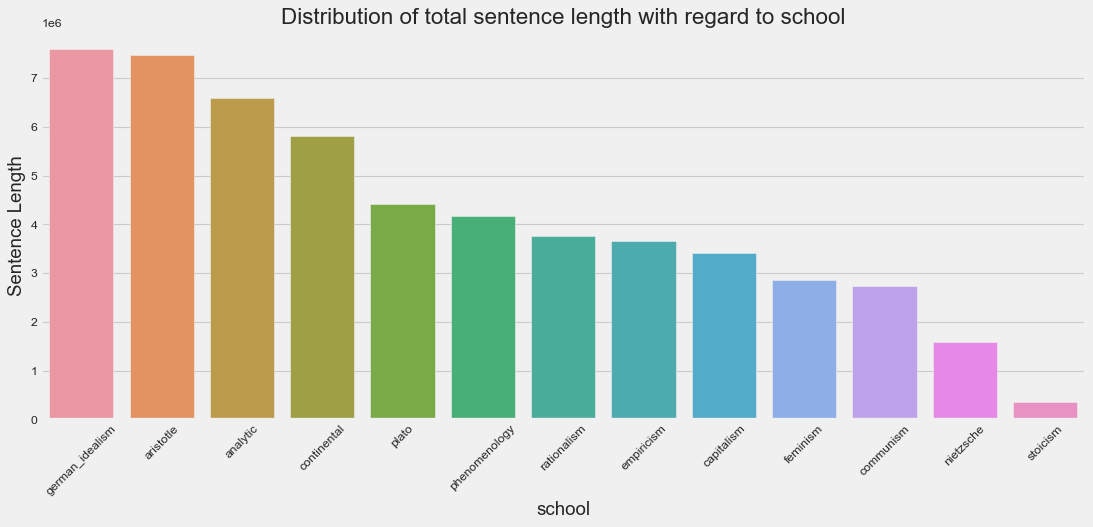

In [129]:
author_length = df.groupby("school").sum("sentence_length").sort_values(by=['sentence_length'], ascending = False)
author_length["school"] = list(author_length.index)
figure(figsize=(15, 6), dpi=80)
sns.barplot(data = author_length, x = "school", y = "sentence_length")
plt.xticks(rotation=45)
plt.ylabel("Sentence Length")
plt.title("Distribution of total sentence length with regard to school")
plt.show()

Next, we import sentiment vectors by using the NRC lexicon and encode each sentence with a sentiment object.

In [7]:
import time
start_time = time.time()
senti_list = []
for i in range(len(df.sentence_lowered)):
    senti_list.append(NRCLex(df.sentence_lowered[i]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 103.42729187011719 seconds ---


Using NRC lexicon, we assign each sentence a vector of sentiments, containing fear, anger, ancitipation, trust, suprise, sadness, disgust and joy. Also, the function computes the extent of positive and negative sentiments of each sentence. We sum up the sentiment measures within each sentence and store them separately in several lists, and then assign them to the original DataFrame.

In [8]:
senti_detail = [senti_list[i].affect_frequencies for i in range(len(senti_list))]

In [9]:
fear = [senti_detail[i]["fear"] for i in range(len(senti_detail))]
anger = [senti_detail[i]["anger"] for i in range(len(senti_detail))]
anticip = [senti_detail[i]["anticip"] for i in range(len(senti_detail))]
trust = [senti_detail[i]["trust"] for i in range(len(senti_detail))]
surprise = [senti_detail[i]["surprise"] for i in range(len(senti_detail))]
positive = [senti_detail[i]["positive"] for i in range(len(senti_detail))]
negative = [senti_detail[i]["negative"] for i in range(len(senti_detail))]
sadness = [senti_detail[i]["sadness"] for i in range(len(senti_detail))]
disgust = [senti_detail[i]["disgust"] for i in range(len(senti_detail))]
joy = [senti_detail[i]["joy"] for i in range(len(senti_detail))]

In [10]:
df["fear"] = fear
df["anger"] = anger
df["anticip"] = anticip
df["trust"] = trust
df["surprise"] = surprise
df["positive"] = positive
df["negative"] = negative
df["sadness"] = sadness
df["disgust"] = disgust
df["joy"] = joy

# Step 1: Sentiment Analysis of mutual interaction of schools

To study each schools' opinion on other schools, and how schools interact with each other, we extract the school list and compute mutual interaction (which involves both mentioning times and sentiments of mentioned sentences) between every possible pair.

In [133]:
school_list = list(df.school.value_counts().index)
senti_types = ["fear","anger","anticip","trust","surprise","sadness","disgust","joy"]
school_group = df.groupby("school").mean(senti_types)

For each (school_1, school_2) pair, we calculate the total mentioning times and store the info into count_lists, and then sum up the total sentiment (by sentiment category) of all school_1's sentences that mention school_2 and store the info into sentiment_lists.

In [78]:
count_lists = []
sentiment_lists = []
for school_1 in school_list:
    count_list = []
    sentiment_list = []
    school_1_data = df[df.school == school_1].reset_index()
    for school_2 in school_list:
        count = 0
        positive = 0
        if school_2 == "german_idealism":
            school_2 = "idealism"
        for i in range(school_1_data.shape[0]):
            if (school_1_data.sentence_lowered[i].find(school_2) != -1):
                count += 1
                if school_1_data.positive[i] > school_1_data.negative[i]:
                    positive += school_1_data.positive[i]
                elif school_1_data.positive[i] == school_1_data.negative[i]:
                    positive += 0
                else:
                    positive -= school_1_data.negative[i]
        count_list.append(count)
        sentiment_list.append(positive)
    count_lists.append(count_list)
    sentiment_lists.append(sentiment_list)

With well-organized lists of data, we convert them into dataframes and set appropriate labels.

In [79]:
mention_df = pd.DataFrame(count_lists)
mention_df.columns = school_list
mention_df.index = school_list
mention_df['sum'] = mention_df.apply(sum, axis = 1)
mention_df.loc['sum',:] = mention_df.apply(sum, axis = 0)

In [80]:
mention_df

,analytic,aristotle,german_idealism,plato,continental,phenomenology,rationalism,empiricism,feminism,capitalism,communism,nietzsche,stoicism,sum
analytic,394.0,107.0,33.0,45.0,2.0,0.0,3.0,29.0,0.0,0.0,1.0,0.0,1.0,615.0
aristotle,27.0,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,102.0
german_idealism,260.0,36.0,110.0,58.0,0.0,26.0,10.0,28.0,0.0,0.0,0.0,0.0,13.0,541.0
plato,1.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,33.0
continental,186.0,37.0,15.0,163.0,1.0,118.0,24.0,38.0,0.0,186.0,1.0,220.0,2.0,991.0
phenomenology,161.0,77.0,50.0,64.0,0.0,150.0,52.0,69.0,0.0,1.0,0.0,118.0,0.0,742.0
rationalism,0.0,168.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0
empiricism,0.0,4.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0
feminism,11.0,10.0,0.0,31.0,0.0,3.0,3.0,0.0,19.0,25.0,1.0,13.0,1.0,117.0
capitalism,1.0,5.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,19.0


With the sum of sentiment values and total mentioning counts, we divide the two dataframes element-wise to get an average sentiment distribution of mutual interactions.

In [86]:
positive_df = pd.DataFrame(sentiment_lists)
positive_df.columns = school_list 
positive_df.index = school_list 

In [87]:
for i in range(positive_df.shape[0]):
    for j in range(positive_df.shape[1]):
        if mention_df.iloc[i,j] >= 10:
            positive_df.iloc[i,j] = positive_df.iloc[i,j]/mention_df.iloc[i,j]
        else:
            positive_df.iloc[i,j] = 0
positive_df

,analytic,aristotle,german_idealism,plato,continental,phenomenology,rationalism,empiricism,feminism,capitalism,communism,nietzsche,stoicism
analytic,0.225174,0.239384,0.367769,0.162174,0.0,0.000000,0.000000,0.231801,0.00000,0.000000,0.000000,0.000000,0.000000
aristotle,0.030471,0.000000,0.000000,0.166508,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
german_idealism,0.307673,0.267301,0.544697,0.154302,0.0,0.573481,0.381667,0.407474,0.00000,0.000000,0.000000,0.000000,0.145018
plato,0.000000,0.000000,0.000000,0.296731,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
continental,0.141405,0.152441,0.276720,0.098943,0.0,0.264090,0.147147,0.244913,0.00000,0.148987,0.000000,0.068497,0.000000
phenomenology,0.270561,0.190957,0.438535,0.199409,0.0,0.416279,0.166762,0.170956,0.00000,0.000000,0.000000,0.100974,0.000000
rationalism,0.000000,0.156412,0.000000,0.103560,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
empiricism,0.000000,0.000000,0.000000,0.394670,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
feminism,-0.057809,0.260703,0.000000,0.117943,0.0,0.000000,0.000000,0.000000,0.20185,0.117782,0.000000,0.037723,0.000000
capitalism,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


Below is a sanity check that the counting function works well. As we could see, the analytic school mentioned empiricism 29 times, and a subset of the sentences found actually mentioned "empiricism", so our subsetting grammar is working well.

In [88]:
analytic_data = df[df.school == "analytic"].reset_index()
analytic_mention_empiricism = []
for i in range(analytic_data.shape[0]):
    if analytic_data.sentence_lowered[i].find("empiricism") != -1:
        analytic_mention_empiricism.append(analytic_data.sentence_lowered[i])

In [89]:
len(analytic_mention_empiricism), analytic_mention_empiricism[:5]

(29,
 ['reprinted in essays in radical empiricism (longmans, green and co., pp.',
  'essays in radical empiricism, pp.',
  "leibniz's conception of many possible worlds seems to accord much better with modern logic and with the practical empiricism which is now universal.",
  'against sensationalism and empiricism they have maintained the true view.',
  'as suggested by paul feyerabend, explanation, reduction, and empiricism, minnesota studies in the philosophy of science (minneapolis:'])

Next, we make two heatmap plots, the first one is about the frequency of each school mentioning other schools, and the second one is about the general emotion of each school towards other schools.

From the heatmap, we could see that 
* Analytic school mentions itself very frequenly, and is also frequently mentioned by idealism, continental and phenomenology. 
* The continental and phenomenology constantly refer to other schools. 
* Communism authors mention capitalism the most frequently, and they also mention their own school, which matches our expectation.

Text(0.5, 1.0, 'Frequency of each school mentioning other schools')

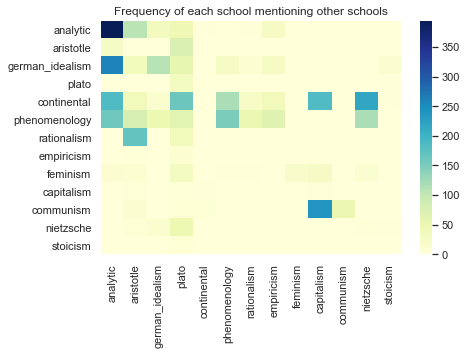

In [209]:
sns.set_theme()
sns.heatmap(mention_df.iloc[:13,:13],cmap="YlGnBu")
plt.title("Frequency of each school mentioning other schools")

Next, we plot the sentiment distribution with the sentiment_df computed above. We could spot some key findings with this plot:
* Idealism holds mostly positive (if not neutral) attitude towards other schools, and it's especially positive towards phenomenology, idealism itself, and empiricism.
* Feminism holds a very negative view towards analytic.
* Plato, idealism and aristotle are generally positively supported by other schools (if not neutral).

<AxesSubplot:>

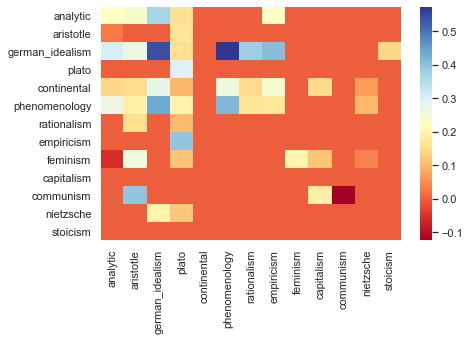

In [90]:
sns.heatmap(positive_df, cmap="RdYlBu")

Now we verify the findings by extracting relevant texts from the original dataset. We define a function to make this easily reproducible.

In [227]:
def verifyAttitude(school_1, school_2, num_sentences):
    count = 0
    school_1_data = df[df.school == school_1].reset_index()
    for i in range(school_1_data.shape[0]):
        if count >= num_sentences:
            break
        else:
            if school_1_data.sentence_lowered[i].count(school_2)>0:
                if school_1_data.positive[i] > school_1_data.negative[i]:
                    print(school_1_data.sentence_lowered[i])
                    print("Positive", school_1_data.positive[i])
                    print("--")
                    count += 1
                if school_1_data.positive[i] < school_1_data.negative[i]:
                    print(school_1_data.sentence_lowered[i])
                    print("Negative", school_1_data.negative[i])
                    print("--")
                    count += 1

* From texts like "the connection of the science that i call phenomenology of spirit to the logic is thereby stated." and "it therefore constitutes the first sequel to the phenomenology of spirit in an expanded plan of the system of science." shows the positive attitude of german_idealism scholars towards phenomenology.

In [223]:
verifyAttitude("german_idealism", "phenomenology", 5)

a phenomenology of spirit, preface to the first edition.
Positive 0.5
--
in this fashion have i tried to portray consciousness in the phenomenology of spirit.
Positive 1.0
--
the connection of the science that i call phenomenology of spirit to the logic is thereby stated.
Positive 1.0
--
as regards the way it stands to it externally, a second part was intended to follow the first part of the system of scienceb that contains the phenomenology.
Positive 0.3333333333333333
--
it therefore constitutes the first sequel to the phenomenology of spirit in an expanded plan of the system of science.
Positive 0.25
--


* The sentence "if the psychoanalytical method is often productive in spite of errors in theory, it is because there are givens in every individual case so generalized that no one would dream of denying them" from feminism scholars clearly shows the negative attitude towards the analytic school.

In [231]:
verifyAttitude("feminism", "analytic", 5)

so we will begin by discussing woman from a biological, psychoanalytical, and historical materialist point of view.
Negative 0.5
--
if the psychoanalytical method is often productive in spite of errors in theory, it is because there are givens in every individual case so generalized that no one would dream of denying them:
Negative 0.3
--
a symbol does not emerge as an allegory worked out by a mysterious unconscious: it is the apprehension of a signification through an analogue of the signifying object; because of the identity of the existential situation cutting across all existents and the identity of the facticity they have to cope with, significations are revealed to many individuals in the same way; symbolism did not fall out of heaven or rise out of subterranean depths: it was elaborated like language, by the human reality that is at once mitsein and separation; and this explains that singular invention also has its place: in practice the psychoanalytical method must accept this 

* The sentence "sharply distinguished from this universal but mythicalpractical attitude is the theoretical attitude, which is not practical in any sense used so far, the attitude of oavpafav, to which the great figures of the first culminating period of greek philosophy, plato and aristotle, traced the origin of philosophy." depicts the positive attitude of phenomenology towards plato.

In [234]:
verifyAttitude("phenomenology", "plato", 5)

plato still allowed the empiricist the power of pointing a finger at things, but the truth is that even this silent gesture is impossible if what is pointed out is not already torn from instantaneous existence and monadic existence, and treated as representative of its previous appearances in me, and of its simultaneous appearances in others, in other words, subsumed under some category and promoted to the status of a concept if the patient is no longer able to point to some part of his body which is touched, it is because he is no longer a subject face to face with an objective world, and can no longer take up a 'categorial attitude'.
Positive 0.35294117647058826
--
natural geometry' or 'natural judgement' are myths in the platonic sense, intended to represent the envelopment or 'implication' of a significance in signs, neither signs nor significance being yet posited and explicitly contained in thought, and this is what we must elucidate by returning to perceptual experience.
Positiv

# Step 2: PCA and K-means clustering of schools

In this part, we start from the sentiment dataset obtained in earlier steps, intending to apply k-means clustering to verify if the clustering pattern is consistent with the analysis above. We first apply PCA algorithm to reduce dimensionality before k-means clustering, so that we could avoid the curse of dimensionality and make the prediction more accurate.

In [236]:
# Set up the PCA and k_means pipeline
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=99)),
    ]
)

clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=3,
               init="k-means++",
               n_init=50,
               max_iter=200,
               random_state=99,
           ),
       ),
   ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

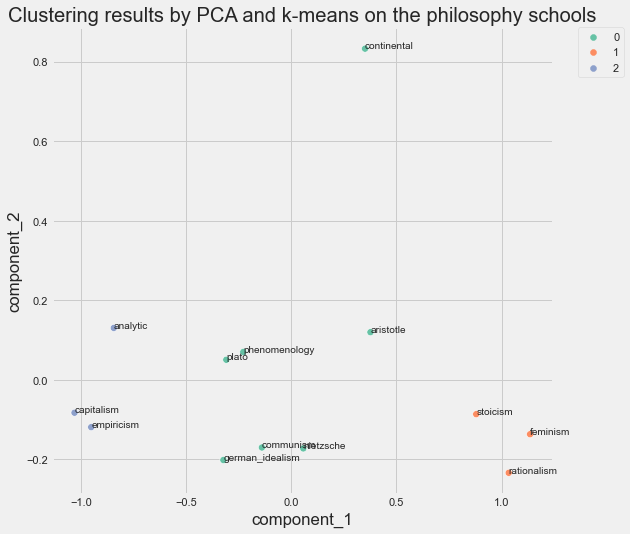

In [237]:
school_group = df.groupby("school").mean(senti_types)
data = school_group[senti_types]
pipe.fit(data)
preprocessed_data = pipe["preprocessor"].transform(data[senti_types])
predicted_labels = pipe["clusterer"]["kmeans"].labels_


pca_result = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)


pca_result['name'] = school_list
pca_result["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pca_result,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title(
    "Clustering results by PCA and k-means on the philosophy schools"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
for i in range(len(school_list)):
    plt.annotate(school_list[i], (pca_result.component_1[i], pca_result.component_2[i]), fontsize = 10)

plt.show()



From this graph, we could discover some findings that are consistent with the sentiment analysis done above.
* German_idealism and phenomenology are in the same group, while in the above analysis they are mutually supportive of each other.
* Feminism and analytic are very far in the graph, which matches there mutual negative attitude.
* Plato and aristotle are in the same group that has the largest size, which matches their popularity among all schools.

# Step 3: K-means clustering of authors according to their attitude towards others

Finally, in this part, we want to examine if the authors of the same school have consistent attitude towards other's view points. We will vectorize the authors with their positive, negative and neutral sentences towards other authors. Sentences that don't involve other schools will not be included.

Now for each author, we find the subset of the author's work and calculate the total number of sentences of each kind, to make k-means more accurate, we normalize each column of the data by subtracting the mean and then divide by standard deviation, so that each dimension plays similarly important role.

In [238]:
author_list = list(df.author.value_counts().index)
positive_counts = []
negative_counts = []
neutral_counts = []
for author in author_list:
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    author_subset = df[df.author == author].reset_index()
    for school in school_list:
        for rowIndex in range(author_subset.shape[0]):
            if author_subset.sentence_lowered[rowIndex].find(school) != -1:
                if author_subset.positive[rowIndex] > author_subset.negative[rowIndex]:
                    positive_count += 1
                elif author_subset.positive[rowIndex] < author_subset.negative[rowIndex]:
                    negative_count += 1
                else:
                    neutral_count += 1
    positive_counts.append(positive_count)
    negative_counts.append(negative_count)
    neutral_counts.append(neutral_count)

In [239]:
author_judgement = pd.DataFrame({"author":author_list})
author_judgement['positive_reviews'] = positive_counts
author_judgement['negative_reviews'] = negative_counts
author_judgement['neutral_reviews'] = neutral_counts

In [240]:
author_judgement.positive_reviews = (author_judgement.positive_reviews-np.mean(author_judgement.positive_reviews))/(np.std(author_judgement.positive_reviews))
author_judgement.negative_reviews = (author_judgement.negative_reviews-np.mean(author_judgement.negative_reviews))/(np.std(author_judgement.negative_reviews))
author_judgement.neutral_reviews = (author_judgement.neutral_reviews-np.mean(author_judgement.neutral_reviews))/(np.std(author_judgement.neutral_reviews))
author_judgement.head()

,author,positive_reviews,negative_reviews,neutral_reviews
0,Aristotle,-0.122939,0.015814,0.278344
1,Plato,-0.430693,-0.482328,-0.586359
2,Hegel,0.917564,0.051396,0.507236
3,Foucault,0.551190,0.940936,0.100317
4,Heidegger,2.368406,2.008384,2.440101


The loss function of k-means suggests that we pick the number of clusters as 4.

Text(0.5, 1.0, 'Total loss against the Number of Cluster k')

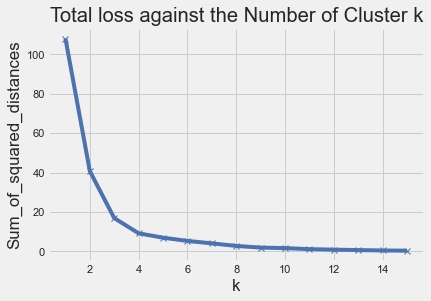

In [241]:
sum_of_squares = []
K = range(1, 16)
for k in K:
    km = k_means(author_judgement[["positive_reviews","negative_reviews","neutral_reviews"]], n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Total loss against the Number of Cluster k')

In [247]:
km = k_means(author_judgement[["positive_reviews","negative_reviews","neutral_reviews"]], n_clusters=3)
labels = km[1]
author_judgement["k_means_label"] = labels

<AxesSubplot:xlabel='positive_reviews', ylabel='negative_reviews'>

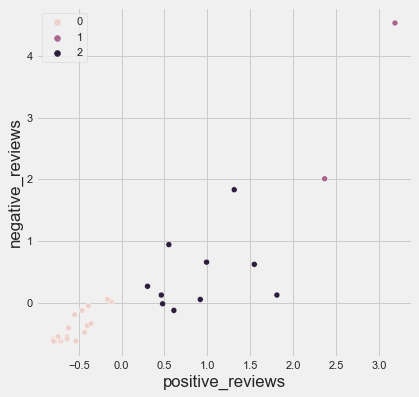

In [248]:
plt.figure(figsize=(6, 6))
sns.scatterplot("positive_reviews", "negative_reviews", data = author_judgement, hue = labels)

In [249]:
author2school = [df[df.author==author].reset_index().school[0] for author in author_list]
author_judgement['school'] = author2school
author_judgement.sort_values(by = "school").head()

,author,positive_reviews,negative_reviews,neutral_reviews,k_means_label,school
12,Kripke,0.477915,-0.019768,0.558101,2,analytic
27,Moore,-0.533278,-0.624655,-0.637224,0,analytic
22,Russell,-0.547933,-0.197676,-0.433764,0,analytic
18,Quine,1.547728,0.620701,1.956884,2,analytic
14,Wittgenstein,-0.797068,-0.589073,-0.662656,0,analytic


In [250]:
school_purity = pd.DataFrame(author_judgement.groupby("school")["k_means_label"].nunique()).reset_index()
school_purity['total_num'] = list(author_judgement.groupby("school")["k_means_label"].count())

In [252]:
school_purity['purity'] = school_purity['total_num']/school_purity['k_means_label']
school_purity.sort_values(by = "purity", ascending = False)

,school,k_means_label,total_num,purity
0,analytic,2,7,3.5
2,capitalism,1,3,3.0
5,empiricism,1,3,3.0
6,feminism,1,3,3.0
11,rationalism,2,4,2.0
12,stoicism,1,2,2.0
4,continental,2,3,1.5
7,german_idealism,2,3,1.5
9,phenomenology,2,3,1.5
1,aristotle,1,1,1.0


From the purity data and number of k-means labels within each school, we could find that 
* Each school is divided into at most 2 subgroups
* Most schools with more than (or equal to) 3 authors are well clustered
* Schools for authors categorized into the same cluster generally match the pattern shown in step 2, which means this clustering outputs consistent results compared with previous methods.

# Summary

In conclusion, the three approaches, the visual analysis of attitude heatmap, PCA and k-means clustering by school, and k-means by author, are yielding consistent results, enhancing each other's correctness. We could discover mutual interactions among schools and authors, and with the agreement of general ideas, we could better understanding the relationship between each philosophical schools and better compare their ideas.

# 